# Zalando Image Dataset

## Setup

In [1]:
!wget https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-images-idx3-ubyte.gz -O ./data/t10k-images-idx3-ubyte.gz
!wget https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-labels-idx1-ubyte.gz -O ./data/t10k-labels-idx1-ubyte.gz
!wget https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-images-idx3-ubyte.gz -O ./data/train-images-idx3-ubyte.gz
!wget https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-labels-idx1-ubyte.gz -O ./data/train-labels-idx1-ubyte.gz

--2022-02-11 07:59:03--  https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-images-idx3-ubyte.gz
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-images-idx3-ubyte.gz [following]
--2022-02-11 07:59:03--  https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-images-idx3-ubyte.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8002::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4422102 (4.2M) [application/octet-stream]
Saving to: './data/t10k-images-idx3-ubyte.gz'

     0K .......... .......... .......... .......... ..

In [2]:
!wget https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/utils/mnist_reader.py -O mnist_reader.py

--2022-02-11 07:59:23--  https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/utils/mnist_reader.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8002::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 756 [text/plain]
Saving to: 'mnist_reader.py'

     0K                                                       100% 37.2M=0s

2022-02-11 07:59:23 (37.2 MB/s) - 'mnist_reader.py' saved [756/756]



In [2]:
import mnist_reader
import time

from matplotlib import pyplot as plt
from PIL import Image

from functools import reduce
import numpy as np
import pandas as pd

from models import do_lda
from models import do_logistic_regression
from models import do_mlp
from models import do_svm

import cv2

from scipy.cluster.vq import kmeans,vq

In [3]:
X_train, y_train = mnist_reader.load_mnist('data', kind='train')
X_test, y_test = mnist_reader.load_mnist('data', kind='t10k')

## Basic Analysis

The data set contains 60.000 images.

In [2]:
X_train.shape

(60000, 784)

These are all 28 by 28 grayscale images.

In [3]:
28 * 28

784

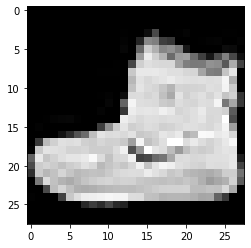

In [15]:
example_image = Image.fromarray(X_train[0].reshape(28, 28), mode='P')
plt.imshow(example_image)

## Simple feature extraction

The simple features that will be extracted are the following:

* binned grayscale values (bin size 32)
* number of black pixels
* number of almost white pixels (any pixel higher or equal to 250)
* average grayscale value of 7x7 pixel regions (16 values in total)

In [3]:
#stolen from TUWEL
flatten = lambda l: [item for sublist in l for item in sublist]

def make_bin(list, min, max, bin_range):
  arr = [0] * int((max - min) / bin_range)
  for i in list:
    bin = int(i / bin_range)
    arr[bin] = arr[bin] + 1
  return arr

def compute_region_brightness(image, region_width):
  avg_regions = []
  #normed_image = min_max_normed(image)
  im = Image.fromarray(image.reshape(28, 28), mode="P")
  for top in range(0, 28, region_width):
    for left in range(0, 28, region_width):
      cropped = im.crop((left, top, left + region_width, top + region_width))
      avg_regions.append(
          np.average(get_grayscale_pixels(cropped))
      )
  return avg_regions
  
def get_grayscale_pixels(image):
  pix = []
  width, height = image.size
  for i in range(0, width):
    for j in range(0, height):
      pix.append(image.getpixel((i,j)))
  return pix

def feature_extraction_zalando(image):
  black_indicator = lambda aggregator, x: aggregator+1 if x == 0 else aggregator+0
  almost_white_indicator = lambda aggregator, x: aggregator+1 if x >= 250 else aggregator+0
  n_black = reduce(black_indicator, image, 0)
  n_almost_white = reduce(almost_white_indicator, image, 0)
  
  bins = make_bin(X_train[1], 0, 256, 32)
  region_brightnesses = compute_region_brightness(X_train[1], 7)

  #sanity checks
  if sum(bins) != 28*28:
    print("WARNING! ERROR OCCURED WHEN CREATING HISTOGRAM BINS!")

  return flatten([[n_black], [n_almost_white], bins, region_brightnesses])

def feature_extraction_zalando_df(data):
  extracted_features = []
  for (index, training_sample) in enumerate(data):
    extracted_features.append(feature_extraction_zalando(training_sample))
    if(index % 1000 == 0):
      print("Progress {}%".format(int((index * 100) / len(data))))
  print("Completed 100%")

  return pd.DataFrame(data=extracted_features, columns=[
    "n_black", 
    "n_almost_white", 
    "<32", "<64", "<96", "<128", "<160", "<192", "<224", "<256",
    "avg_col_region_0_0", "avg_col_region_0_1", "avg_col_region_0_2", "avg_col_region_0_3",
    "avg_col_region_1_0", "avg_col_region_1_1", "avg_col_region_1_2", "avg_col_region_1_3",
    "avg_col_region_2_0", "avg_col_region_2_1", "avg_col_region_2_2", "avg_col_region_2_3",
    "avg_col_region_3_0", "avg_col_region_3_1", "avg_col_region_3_2", "avg_col_region_3_3"])


In [41]:
start_time = time.time()
df_zalando_simple_train = feature_extraction_zalando_df(X_train)
print("Execution took {} seconds.".format(time.time() - start_time))
df_zalando_simple_train.to_csv("saves/zalando_simple_train.csv")

Progress 0%
Progress 1%
Progress 3%
Progress 5%
Progress 6%
Progress 8%
Progress 10%
Progress 11%
Progress 13%
Progress 15%
Progress 16%
Progress 18%
Progress 20%
Progress 21%
Progress 23%
Progress 25%
Progress 26%
Progress 28%
Progress 30%
Progress 31%
Progress 33%
Progress 35%
Progress 36%
Progress 38%
Progress 40%
Progress 41%
Progress 43%
Progress 45%
Progress 46%
Progress 48%
Progress 50%
Progress 51%
Progress 53%
Progress 55%
Progress 56%
Progress 58%
Progress 60%
Progress 61%
Progress 63%
Progress 65%
Progress 66%
Progress 68%
Progress 70%
Progress 71%
Progress 73%
Progress 75%
Progress 76%
Progress 78%
Progress 80%
Progress 81%
Progress 83%
Progress 85%
Progress 86%
Progress 88%
Progress 90%
Progress 91%
Progress 93%
Progress 95%
Progress 96%
Progress 98%
Completed 100%
Execution took 366.5931603908539 seconds.


In [42]:
start_time = time.time()
df_zalando_simple_test = feature_extraction_zalando_df(X_test)
print("Execution took {} seconds.".format(time.time() - start_time))
df_zalando_simple_test.to_csv("saves/zalando_simple_test.csv")

Progress 0%
Progress 1%
Progress 3%
Progress 5%
Progress 6%
Progress 8%
Progress 10%
Progress 11%
Progress 13%
Progress 15%
Completed 100%
Execution took 60.812066316604614 seconds.


In [4]:
#reloading the data from save point
df_zalando_simple_train = pd.read_csv("saves/zalando_simple_train.csv", index_col=0)
df_zalando_simple_test = pd.read_csv("saves/zalando_simple_test.csv", index_col=0)

### Classification

Algorithms used:

* Logistic Regression
* LDA
* SVM
* MLP

See `models.py`.

#### Logistic Regression

Classification report for Logistic Regression
Accuracy score: 0.2951
Recall score: 0.2951
Precision score: 0.29100838925645667


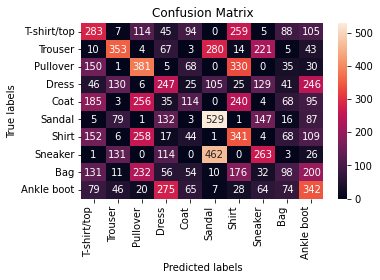

In [5]:
do_logistic_regression(df_zalando_simple_train, y_train, df_zalando_simple_test, y_test, "./results/zalando_simple_logistic_regression_{}")

#### LDA

Classification report for LDA
Accuracy score: 0.2917
Recall score: 0.2917
Precision score: 0.29018517345037015


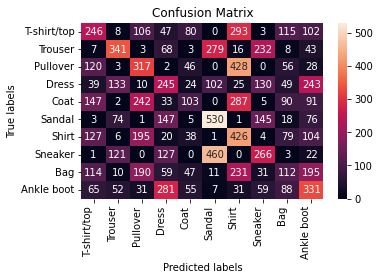

In [6]:
do_lda(df_zalando_simple_train, y_train, df_zalando_simple_test, y_test, "./results/zalando_simple_lda_{}")

#### SVM

In [7]:
do_svm(df_zalando_simple_train, y_train, df_zalando_simple_test, y_test, "./results/zalando_simple_svm_{}")

KeyboardInterrupt: 

#### MLP

Classification report for MLP
Accuracy score: 0.3071
Recall score: 0.3071
Precision score: 0.3787713637566066


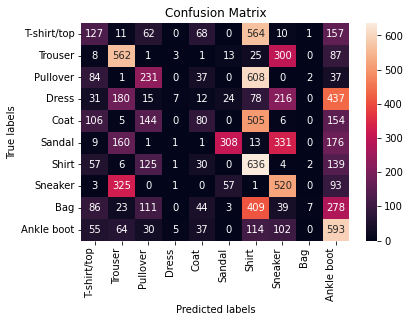

In [ ]:
do_mlp(df_zalando_simple_train, y_train, df_zalando_simple_test, y_test, "./results/zalando_simple_mlp_{}")

## SIFT and Visual Bag of Words

In [16]:
k_for_k_means = 200

def compute_descriptor_list(images):
    sift = cv2.xfeatures2d.SIFT_create()
    descriptor_list = []
    print("Computing descriptors...")
    for (index, image) in enumerate(images):
        image = image.reshape(28, 28)
        keypoints, descriptors = sift.detectAndCompute(image, None)
        if descriptors is not None:
            descriptor_list.append(descriptors)
        else:
            descriptor_list.append(np.empty((1, 128), dtype=float))
        if index % 2000 == 0:
            print("Progress {}%".format(int(index / len(images) * 100)))
    print("Finished computing descriptors!")
    return descriptor_list

def unwrap_descriptor_list(descriptor_list):
    print("Unwrapping descriptors...")
    descriptors = descriptor_list[0]
    for (index, descriptor) in enumerate(descriptor_list[1:]):
        descriptors = np.vstack((descriptors, descriptor))
        if index % 2000 == 0:
            print("Progress {}%".format(index / len(descriptor_list) * 100))
    print("Finished unwrapping descriptors!")
    return descriptors

def change_descriptors_to_float(descriptors):
    return descriptors.astype(float)

def compute_vocabulary(descriptor_list_float):
    print("Computing K Means groups for k={}...".format(k_for_k_means))
    voc, variance = kmeans(descriptor_list_float, k_for_k_means, 1)
    print("Finished computing K means!")
    return voc

def compute_image_features(descriptors_list, vocabulary):
    im_features = np.zeros((len(descriptors_list), k_for_k_means), "float32")
    for i in range(len(descriptors_list)):
        if(len(descriptors_list[i]) > 0):
            words, distance = vq(descriptors_list[i], vocabulary)
            for w in words:
                im_features[i][w]+=1
    return im_features

In [12]:
train_descriptor_list = compute_descriptor_list(X_train)
train_unwrapped_descriptor_list = unwrap_descriptor_list(train_descriptor_list)
train_descriptor_list_float = change_descriptors_to_float(train_unwrapped_descriptor_list)
vocabulary = compute_vocabulary(train_descriptor_list_float)
train_image_features = compute_image_features(train_descriptor_list, vocabulary)
df_train_image_features = pd.DataFrame(data=train_image_features)
df_train_image_features.to_csv("saves/zalando_sift_train.csv", index=False)

Computing descriptors...
Progress 0%
Progress 3%
Progress 6%
Progress 10%
Progress 13%
Progress 16%
Progress 20%
Progress 23%
Progress 26%
Progress 30%
Progress 33%
Progress 36%
Progress 40%
Progress 43%
Progress 46%
Progress 50%
Progress 53%
Progress 56%
Progress 60%
Progress 63%
Progress 66%
Progress 70%
Progress 73%
Progress 76%
Progress 80%
Progress 83%
Progress 86%
Progress 90%
Progress 93%
Progress 96%
Finished computing descriptors!
Unwrapping descriptors...
Progress 0.0%
Progress 3.3333333333333335%
Progress 6.666666666666667%
Progress 10.0%
Progress 13.333333333333334%
Progress 16.666666666666664%
Progress 20.0%
Progress 23.333333333333332%
Progress 26.666666666666668%
Progress 30.0%
Progress 33.33333333333333%
Progress 36.666666666666664%
Progress 40.0%
Progress 43.333333333333336%
Progress 46.666666666666664%
Progress 50.0%
Progress 53.333333333333336%
Progress 56.666666666666664%
Progress 60.0%
Progress 63.33333333333333%
Progress 66.66666666666666%
Progress 70.0%
Progress 

In [47]:
test_descriptor_list = compute_descriptor_list(X_test)
test_unwrapped_descriptor_list = unwrap_descriptor_list(test_descriptor_list)
test_descriptor_list_float = change_descriptors_to_float(test_unwrapped_descriptor_list)
vocabulary = compute_vocabulary(test_descriptor_list_float)
test_image_features = compute_image_features(test_descriptor_list, vocabulary)

df_test_image_features = pd.DataFrame(data=test_image_features)
df_test_image_features.to_csv("saves/zalando_sift_test.csv", index=False)

Computing descriptors...
Progress 0%
Progress 20%
Progress 40%
Progress 60%
Progress 80%
Finished computing descriptors!
Unwrapping descriptors...
Progress 0.0%
Progress 20.0%
Progress 40.0%
Progress 60.0%
Progress 80.0%
Finished unwrapping descriptors!
Computing K Means groups for k=200...
Finished computing K means!


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df_train_image_features = pd.read_csv("saves/zalando_sift_train.csv")
df_test_image_features = pd.read_csv("saves/zalando_sift_test.csv")
print("Reloaded both train and test split!")

Reloaded both train and test split!


In [9]:
df_train_image_features.sum(axis="columns")

0         5.0
1         8.0
2         1.0
3         2.0
4         6.0
         ... 
59995     5.0
59996     1.0
59997     2.0
59998     3.0
59999    12.0
Length: 60000, dtype: float64

In [43]:
len(test_descriptor_list[4][0])

128

### Classification

#### Logistic Regression

Classification report for Logistic Regression
Accuracy score: 0.1441
Recall score: 0.1441
Precision score: 0.07172363439604819


C:\Users\Paul\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


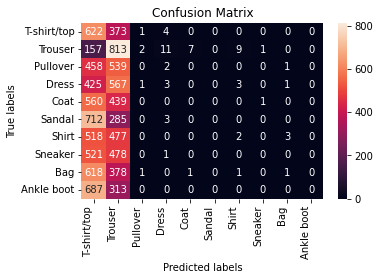

In [10]:
do_logistic_regression(df_train_image_features, y_train, df_test_image_features, y_test, "./results/zalando_sift_log_res_{}")

#### LDA

Classification report for LDA
Accuracy score: 0.0947
Recall score: 0.0947
Precision score: 0.05087515533114834


C:\Users\Paul\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


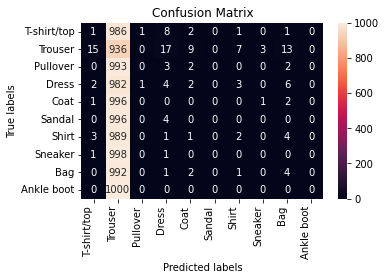

In [11]:
do_lda(df_train_image_features, y_train, df_test_image_features, y_test, "./results/zalando_sift_lda_{}")

#### SVM

In [12]:
do_svm(df_train_image_features, y_train, df_test_image_features, y_test, "./results/zalando_sift_svm_{}")

#### MLP

Classification report for MLP
Accuracy score: 0.094
Recall score: 0.094
Precision score: 0.05043356488655187


C:\Users\Paul\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


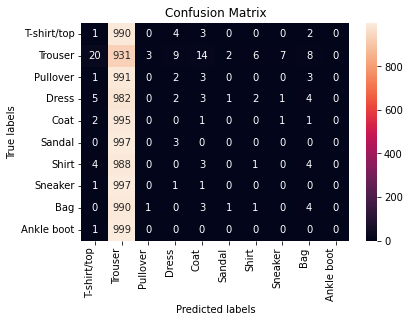

In [ ]:
do_mlp(df_train_image_features, y_train, df_test_image_features, y_test, "./results/zalando_sift_mlp_{}")